# CSE-CIC-IDS2018 Exploratory Data Analysis

This notebook explores the CSE-CIC-IDS2018 network intrusion detection dataset.

## Objectives:
1. Load data using Pandas
2. Understand data quality and missing values
3. Analyze label distribution and class imbalance
4. Explore feature correlations
5. Identify temporal patterns in attacks
6. Characterize different attack types

In [17]:
# Import libraries
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

## 1. Load Data from S3

In [18]:
# Load sample for EDA
from pathlib import Path

project_root = Path().resolve()

data_path = project_root / 'data' / 'raw' / 'friday_02_03_2018_combined_HEAD.csv'

df = pd.read_csv(data_path)

print(f"Loaded {len(df):,} records")
print(f"Number of features: {len(df.columns)}")

Loaded 198 records
Number of features: 323


In [19]:
print(f"Pandas DataFrame shape: {df.shape}")
df.head()

Pandas DataFrame shape: (198, 323)


,flow_id,timestamp,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,...,min_fwd_payload_bytes_delta_len,max_fwd_payload_bytes_delta_len,mean_fwd_payload_bytes_delta_len,mode_fwd_payload_bytes_delta_len,variance_fwd_payload_bytes_delta_len,std_fwd_payload_bytes_delta_len,median_fwd_payload_bytes_delta_len,skewness_fwd_payload_bytes_delta_len,cov_fwd_payload_bytes_delta_len,label
0,172.31.64.111_49459_13.33.140.196_443_TCP_2018...,2018-03-02 07:46:53.346213,172.31.64.111,49459,13.33.140.196,443,TCP,0.362842,18,10,...,-202.0,202.0,0.0,0.0,19836.2222,140.8411,0.0,0.1170,inf,Benign
1,172.31.64.111_49481_72.21.81.200_443_TCP_2018-...,2018-03-02 07:46:56.615096,172.31.64.111,49481,72.21.81.200,443,TCP,0.277040,25,11,...,-199.0,199.0,0.0,0.0,18622.6000,136.4646,0.0,0.0000,inf,Benign
2,172.31.64.111_49482_72.21.81.200_443_TCP_2018-...,2018-03-02 07:46:56.615224,172.31.64.111,49482,72.21.81.200,443,TCP,0.277020,27,13,...,-199.0,199.0,0.0,0.0,11444.8333,106.9805,0.0,-0.3394,inf,Benign
3,172.31.64.111_49483_72.21.81.200_443_TCP_2018-...,2018-03-02 07:46:56.615340,172.31.64.111,49483,72.21.81.200,443,TCP,0.277016,25,11,...,-199.0,199.0,0.0,0.0,18622.6000,136.4646,0.0,0.0000,inf,Benign
4,172.31.64.111_49488_104.20.222.36_443_TCP_2018...,2018-03-02 07:46:56.887585,172.31.64.111,49488,104.20.222.36,443,TCP,0.174763,19,11,...,-194.0,192.0,0.0,0.0,13213.6000,114.9504,0.0,-0.3599,inf,Benign


## 2. Data Quality Analysis

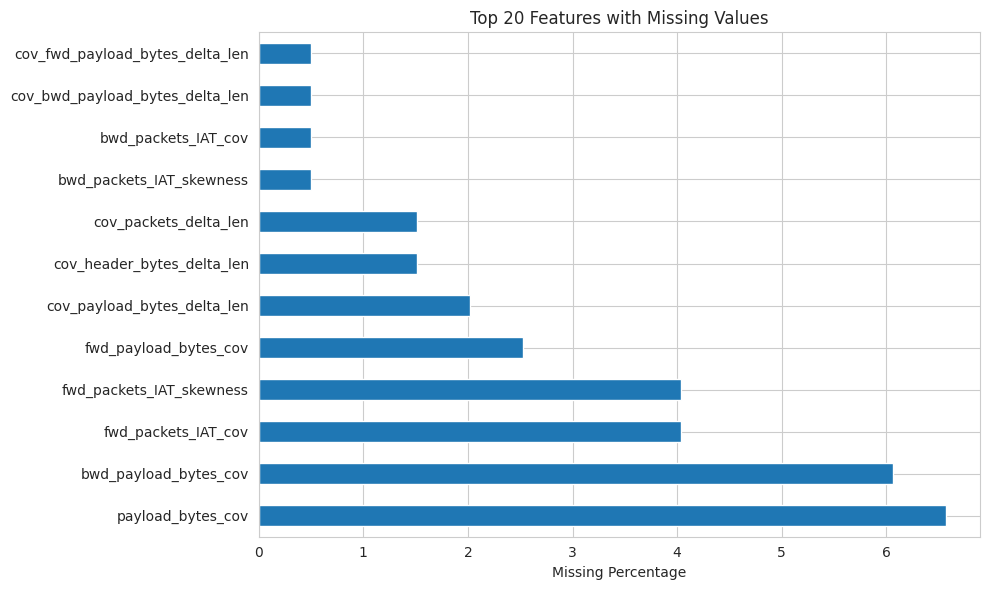

In [21]:
# Check missing values
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

if len(missing_pct) > 0:
    plt.figure(figsize=(10, 6))
    missing_pct.head(20).plot(kind='barh')
    plt.xlabel('Missing Percentage')
    plt.title('Top 20 Features with Missing Values')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

## 3. Label Distribution

In [23]:
# Label distribution
label_counts = df['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)
print(f"\nClass imbalance ratio: {label_counts.max() / label_counts.min():.2f}")


Label Distribution:
label
Benign    99
Bot       99
Name: count, dtype: int64

Class imbalance ratio: 1.00


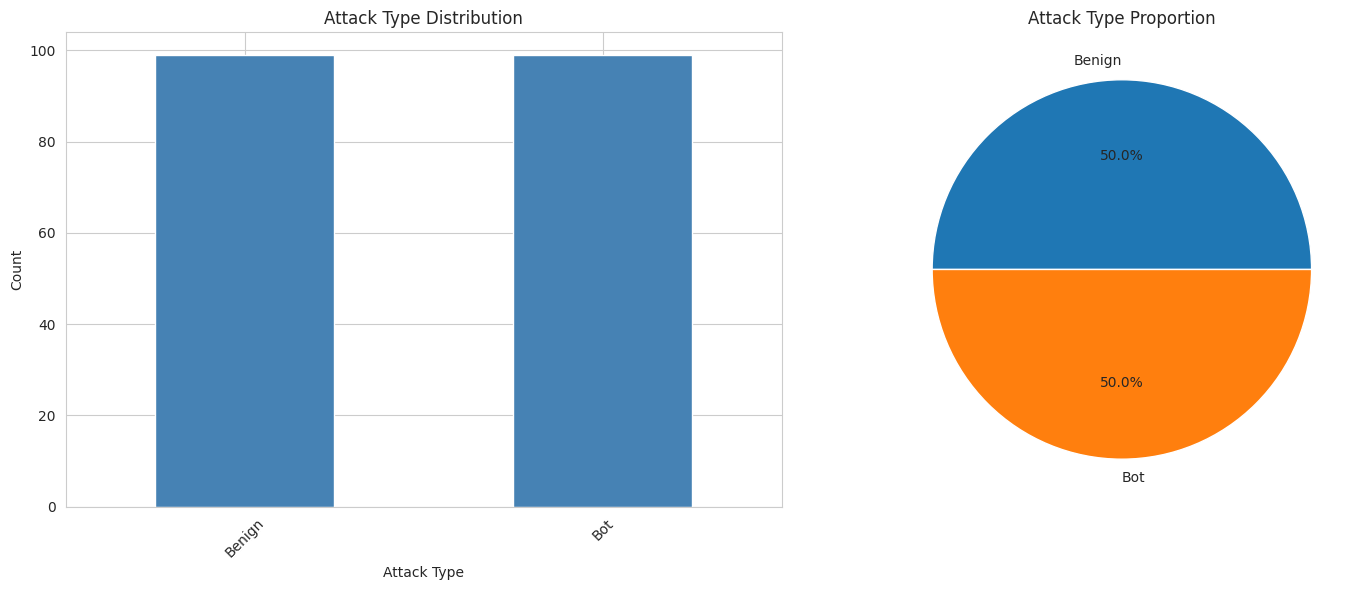

In [24]:
# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Attack Type Distribution')
ax1.set_xlabel('Attack Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
label_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_ylabel('')
ax2.set_title('Attack Type Proportion')

plt.tight_layout()
plt.show()

## 4. Feature Correlation Analysis

Found 316 numeric features

First 20 numeric columns:
['src_port', 'dst_port', 'duration', 'packets_count', 'fwd_packets_count', 'bwd_packets_count', 'total_payload_bytes', 'fwd_total_payload_bytes', 'bwd_total_payload_bytes', 'payload_bytes_max', 'payload_bytes_min', 'payload_bytes_mean', 'payload_bytes_std', 'payload_bytes_variance', 'payload_bytes_median', 'payload_bytes_skewness', 'payload_bytes_cov', 'payload_bytes_mode', 'fwd_payload_bytes_max', 'fwd_payload_bytes_min']

Using 8 features for correlation analysis


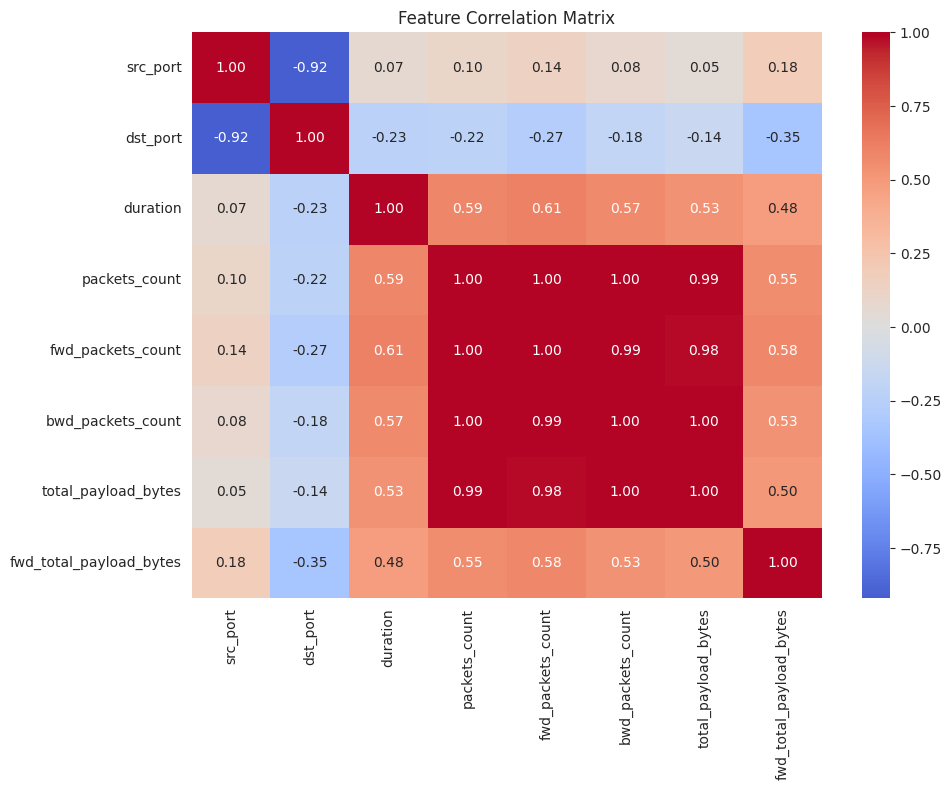

In [28]:
# Select numeric features for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove label column if present
label_cols = ['label', 'Label', 'label_name']
numeric_cols = [c for c in numeric_cols if c not in label_cols]

print(f"Found {len(numeric_cols)} numeric features")
print("\nFirst 20 numeric columns:")
print(numeric_cols[:20])

# Select top features by name similarity (adjust based on actual column names)
# Use columns that actually exist in the dataset
if len(numeric_cols) >= 8:
    # Take first 8 numeric features for correlation
    key_features = numeric_cols[:8]
else:
    key_features = numeric_cols

print(f"\nUsing {len(key_features)} features for correlation analysis")

corr_matrix = df[key_features].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Attack Characteristics

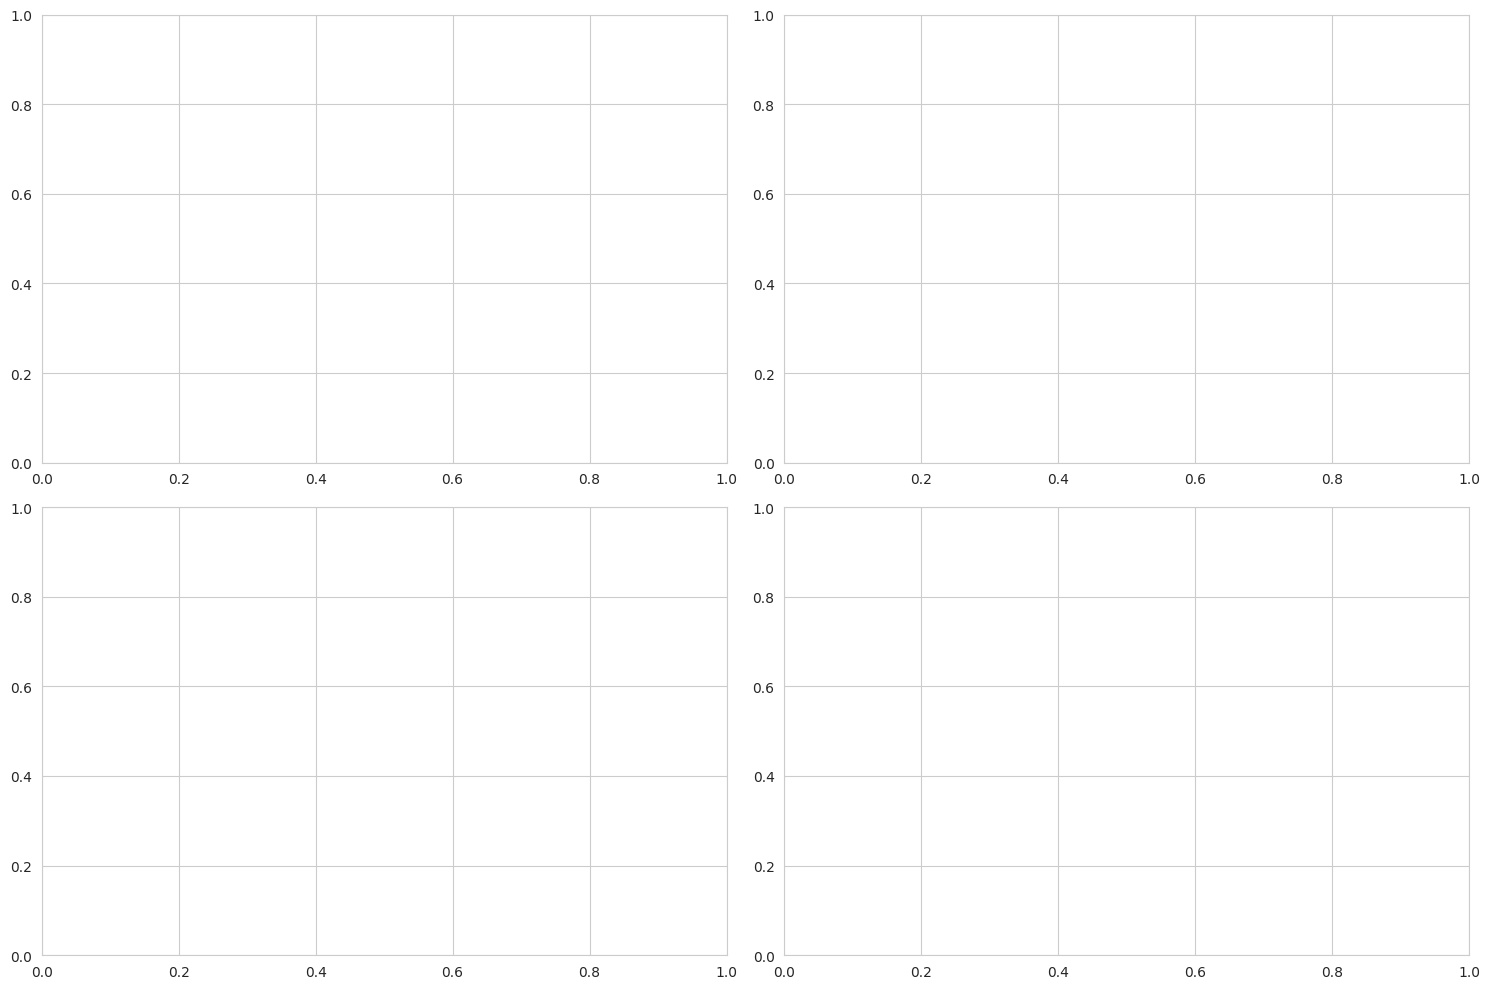

In [27]:
# Compare benign vs attack flows
df['is_attack'] = (df['label'] != 'Benign').astype(int)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot = [
    ('Flow Duration', axes[0, 0]),
    ('Tot Fwd Pkts', axes[0, 1]),
    ('Flow Byts/s', axes[1, 0]),
    ('Flow Pkts/s', axes[1, 1])
]

for feature, ax in features_to_plot:
    if feature in df.columns:
        benign = df[df['is_attack'] == 0][feature].dropna()
        attack = df[df['is_attack'] == 1][feature].dropna()
        
        ax.hist([benign, attack], label=['Benign', 'Attack'], bins=50, alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_title(f'{feature} Distribution')
        ax.legend()
        ax.set_yscale('log')

plt.tight_layout()
plt.show()

## 6. Next Steps

Based on this EDA:
1. Class imbalance requires special handling (SMOTE, class weights)
2. Some features show strong correlation - consider dimensionality reduction
3. Attack types have distinct characteristics - feature engineering opportunities
4. Temporal patterns suggest time-based features are important

Proceed to:
- `02_feature_engineering.ipynb` for advanced feature creation
- `03_model_training.ipynb` for model development